In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-05-12',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2024-12-16,27.700,29.59,27.2700,29.44,8700033.0
2024-12-17,29.635,31.88,29.6350,31.26,19948086.0
2024-12-18,31.100,31.70,28.3400,28.55,13947264.0
2024-12-19,29.155,30.60,28.8200,29.00,10338215.0
2024-12-20,28.540,30.52,28.3093,29.82,19606720.0
...,...,...,...,...,...
2025-05-06,26.440,26.50,25.6650,26.04,5883843.0
2025-05-07,26.190,26.34,25.8800,26.01,4386935.0
2025-05-08,26.300,26.99,26.1800,26.78,6521684.0
2025-05-09,26.780,27.73,26.7600,27.54,7795212.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2024-12-16    1
2024-12-17    1
2024-12-18    1
2024-12-19    1
2024-12-20    1
             ..
2025-05-06    1
2025-05-07    1
2025-05-08    1
2025-05-09    1
2025-05-12    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

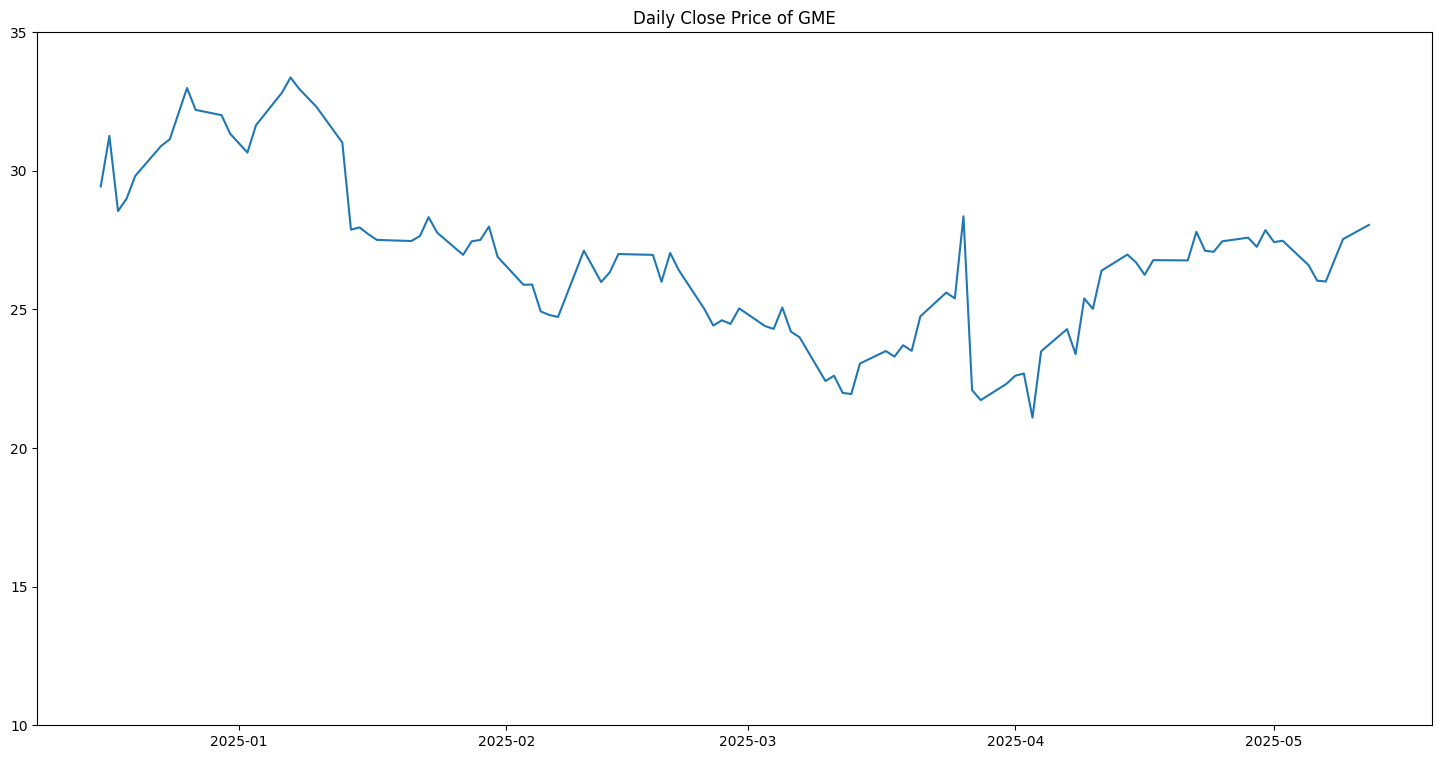

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

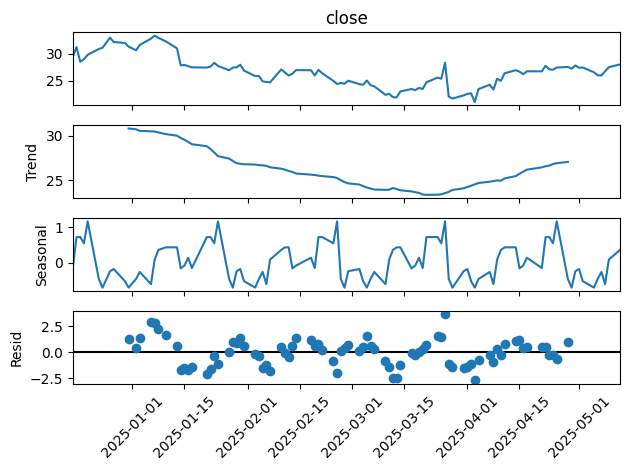

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': 'Where Will Palantir Stock Be in 3 Years?',
  'url': 'https://www.fool.com/investing/2025/05/09/where-will-palantir-stock-be-in-3-years/',
  'time_published': '20250509T113000',
  'authors': ['Will Ebiefung'],
  'summary': 'With its shares up 58% year to date, Palantir Technologies ( NASDAQ: PLTR ) embarrassed its naysayers -- it has been repeatedly testing new highs despite calls of overvaluation. But on some level, the excitement is understandable.',
  'banner_image': 'https://g.foolcdn.com/image/?url=https%3A%2F%2Fg.foolcdn.com%2Feditorial%2Fimages%2F817422%2Fgettyimages-1433587895.jpg&op=resize&w=700',
  'source': 'Motley Fool',
  'category_within_source': 'n/a',
  'source_domain': 'www.fool.com',
  'topics': [{'topic': 'IPO', 'relevance_score': '0.158519'},
   {'topic': 'Retail & Wholesale', 'relevance_score': '0.333333'},
   {'topic': 'Financial Markets', 'relevance_score': '0.413559'},
   {'topic': 'Manufacturing', 'relevance_score': '0.333333'},
   {'topic': 'Earning

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,Where Will Palantir Stock Be in 3 Years?,20250509T113000,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,Neutral,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,Neutral
1,Metaplanet is raising another $21M through bon...,20250509T061818,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,Neutral,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,Neutral
2,GameStop ( GME ) Stock Sinks As Market Gains...,20250507T214512,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.235485,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.4499,0.320818,Somewhat-Bullish
3,Bitcoin for Shares? Strive Asset Management Un...,20250507T205715,André Beganski,Strive Asset Management is adopting Bitcoin as...,Decrypt.co,0.135833,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.163354,0.233091,Somewhat-Bullish
4,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,20250507T102005,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,Neutral
5,Billionaire Bill Ackman Thinks Hertz Stock Cou...,20250506T140700,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral
6,Stephan Tetrault Acquires GameStop Canada,20250505T201500,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,Bullish,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,Bullish
7,Here is What to Know Beyond Why GameStop Corp....,20250505T130012,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,Somewhat-Bullish
8,Looking Into GameStop's Recent Short Interest ...,20250502T130037,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,Neutral
9,If You Invested $1000 In This Stock 5 Years Ag...,20250430T164515,Benzinga Insights,GameStop GME has outperformed the market over ...,Benzinga,0.250000,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.941873,0.382786,Bullish


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Will Ebiefung', 'Stephen Katte', 'Zacks Equity Research',
       'André Beganski', 'Adam Spatacco', 'PRNewswire',
       'Benzinga Insights', 'Christopher Tepedino', 'Andrew Rocco',
       'Surbhi Jain', 'Brayden Lindrea', 'Brian Bolan', 'Adam Eckert',
       'Henry Khederian', 'Globe Newswire', 'Bram Berkowitz',
       'Rishabh Mishra', 'Vaishali Prayag', 'Aniket Verma',
       'Motley Fool Staff', 'Derek Lewis', 'Ritujay Ghosh',
       'Sanghamitra Saha', 'Nalak Das', 'Akanksha Bakshi',
       'Murtuza J Merchant', 'Proiti Seal Acharya'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-05-09,Where Will Palantir Stock Be in 3 Years?,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,Neutral,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,Neutral
2025-05-09,Metaplanet is raising another $21M through bon...,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,Neutral,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,Neutral
2025-05-07,GameStop ( GME ) Stock Sinks As Market Gains...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.235485,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.4499,0.320818,Somewhat-Bullish
2025-05-07,Bitcoin for Shares? Strive Asset Management Un...,André Beganski,Strive Asset Management is adopting Bitcoin as...,Decrypt.co,0.135833,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.163354,0.233091,Somewhat-Bullish
2025-05-07,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,Neutral
2025-05-06,Billionaire Bill Ackman Thinks Hertz Stock Cou...,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral
2025-05-05,Stephan Tetrault Acquires GameStop Canada,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,Bullish,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,Bullish
2025-05-05,Here is What to Know Beyond Why GameStop Corp....,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,Somewhat-Bullish
2025-05-02,Looking Into GameStop's Recent Short Interest ...,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,Neutral


In [24]:
news.groupby(news.index.date).size()

2025-04-07    1
2025-04-08    5
2025-04-09    1
2025-04-10    2
2025-04-11    4
2025-04-14    2
2025-04-15    1
2025-04-16    2
2025-04-17    2
2025-04-18    1
2025-04-21    1
2025-04-22    2
2025-04-23    4
2025-04-24    5
2025-04-25    5
2025-04-28    1
2025-04-29    1
2025-04-30    1
2025-05-02    1
2025-05-05    2
2025-05-06    1
2025-05-07    3
2025-05-09    2
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-05-09,Where Will Palantir Stock Be in 3 Years?,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,Neutral,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,Neutral
2025-05-09,Metaplanet is raising another $21M through bon...,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,Neutral,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,Neutral
2025-05-07,GameStop ( GME ) Stock Sinks As Market Gains...,Zacks Equity Research,The latest trading day saw GameStop (GME) sett...,Zacks Commentary,0.235485,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.4499,0.320818,Somewhat-Bullish
2025-05-07,Bitcoin for Shares? Strive Asset Management Un...,André Beganski,Strive Asset Management is adopting Bitcoin as...,Decrypt.co,0.135833,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.163354,0.233091,Somewhat-Bullish
2025-05-07,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,Neutral
2025-05-06,Billionaire Bill Ackman Thinks Hertz Stock Cou...,Adam Spatacco,Certain personalities on Wall Street have the ...,Motley Fool,0.167199,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.049835,0.06195,Neutral
2025-05-05,Stephan Tetrault Acquires GameStop Canada,PRNewswire,"TORONTO, May 5, 2025 /PRNewswire/ - Stephan Te...",Benzinga,0.367348,Bullish,"Mergers & Acquisitions, Retail & Wholesale",GME,0.584328,0.529335,Bullish
2025-05-05,Here is What to Know Beyond Why GameStop Corp....,Zacks Equity Research,Zacks.com users have recently been watching Ga...,Zacks Commentary,0.264318,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.526867,0.185794,Somewhat-Bullish
2025-05-02,Looking Into GameStop's Recent Short Interest ...,Benzinga Insights,GameStop's GME short percent of float has rise...,Benzinga,0.294277,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.205807,0.148288,Neutral


In [27]:
news['overall_sentiment_label'].unique()

array(['Neutral', 'Somewhat-Bullish', 'Bullish'], dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Neutral', 'Somewhat-Bullish', 'Bullish'], dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_16560\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_16560\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-16,27.700,29.59,27.2700,29.44,8700033.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-17,29.635,31.88,29.6350,31.26,19948086.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-18,31.100,31.70,28.3400,28.55,13947264.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-19,29.155,30.60,28.8200,29.00,10338215.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-20,28.540,30.52,28.3093,29.82,19606720.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-07,26.190,26.34,25.8800,26.01,4386935.0,Is Nuveen ESG Small-Cap ETF ( NUSC ) a Stron...,Zacks Equity Research,Smart Beta ETF report for ...,Zacks Commentary,0.225040,4.0,"Retail & Wholesale, Financial Markets, Technol...",GME,0.116914,0.054712,3.0
2025-05-08,26.300,26.99,26.1800,26.78,6521684.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2025-05-09,26.780,27.73,26.7600,27.54,7795212.0,Where Will Palantir Stock Be in 3 Years?,Will Ebiefung,"With its shares up 58% year to date, Palantir ...",Motley Fool,0.131610,3.0,"IPO, Retail & Wholesale, Financial Markets, Ma...",GME,0.065866,-0.048667,3.0
2025-05-09,26.780,27.73,26.7600,27.54,7795212.0,Metaplanet is raising another $21M through bon...,Stephen Katte,"Fresh off its most recent Bitcoin purchase, Ja...",Cointelegraph,0.080201,3.0,"Retail & Wholesale, Financial Markets, Mergers...",GME,0.211191,0.107285,3.0


In [31]:
merged_df.dtypes

open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
title                       object
authors                     object
summary                     object
source                      object
overall_sentiment_score    float64
overall_sentiment_label    float64
topics                      object
ticker                      object
ticker_relevance_score      object
ticker_sentiment_score      object
ticker_sentiment_label     float64
dtype: object

In [32]:
merged_df['ticker_relevance_score'] = merged_df['ticker_relevance_score'].astype(float)
merged_df['ticker_sentiment_score'] = merged_df['ticker_sentiment_score'].astype(float)

In [33]:
merged_df = merged_df.drop(columns = ['title','topics','ticker','authors','summary','source'])
merged_df

,open,high,low,close,volume,overall_sentiment_score,overall_sentiment_label,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-16,27.700,29.59,27.2700,29.44,8700033.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-17,29.635,31.88,29.6350,31.26,19948086.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-18,31.100,31.70,28.3400,28.55,13947264.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-19,29.155,30.60,28.8200,29.00,10338215.0,0.000000,0.0,0.000000,0.000000,0.0
2024-12-20,28.540,30.52,28.3093,29.82,19606720.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-05-07,26.190,26.34,25.8800,26.01,4386935.0,0.225040,4.0,0.116914,0.054712,3.0
2025-05-08,26.300,26.99,26.1800,26.78,6521684.0,0.000000,0.0,0.000000,0.000000,0.0
2025-05-09,26.780,27.73,26.7600,27.54,7795212.0,0.131610,3.0,0.065866,-0.048667,3.0
2025-05-09,26.780,27.73,26.7600,27.54,7795212.0,0.080201,3.0,0.211191,0.107285,3.0


## LSTM Model

In [34]:
# Split off target
features = merged_df.drop(columns=['close'])
target = merged_df[['close']]

# Normalize
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target)

# Reassemble DataFrame
scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
scaled_df['close'] = target_scaled

In [35]:
def create_lstm_dataset(data, target_column, look_back):
    """
    Convert a dataframe into LSTM-compatible 3D sequences for a specific target column.
    
    Parameters:
    - data: pandas DataFrame (rows = time, cols = features)
    - target_column: name of the column to predict (e.g., 'Close')
    - look_back: number of past time steps to include

    Returns:
    - X: shape (num_samples, look_back, num_features)
    - y: shape (num_samples,)
    """
    # Extract features and target column
    features = data.drop(columns=[target_column]).values  # All columns except target
    target = data[target_column].values  # Target column
    
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(features[i:i+look_back])  # Look-back window of features
        y.append(target[i + look_back])  # Next time-step's target value
        
    return np.array(X), np.array(y)
look_back = 10
X, y = create_lstm_dataset(scaled_df, target_column='close', look_back=look_back)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False,test_size=0.10)

In [37]:
# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

C:\Users\graha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Needed for val_loss monitoring
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.1155 - val_loss: 0.0210
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0243 - val_loss: 0.0265
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0285 - val_loss: 9.9459e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0158 - val_loss: 0.0065
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146 - val_loss: 0.0023
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0158 - val_loss: 0.0031
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - val_loss: 0.0028
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0124 - val_loss: 0.0050
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0130 - val_loss: 0.0044
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143 - val_loss: 0.0055
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0125 - val_loss: 0.0063
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


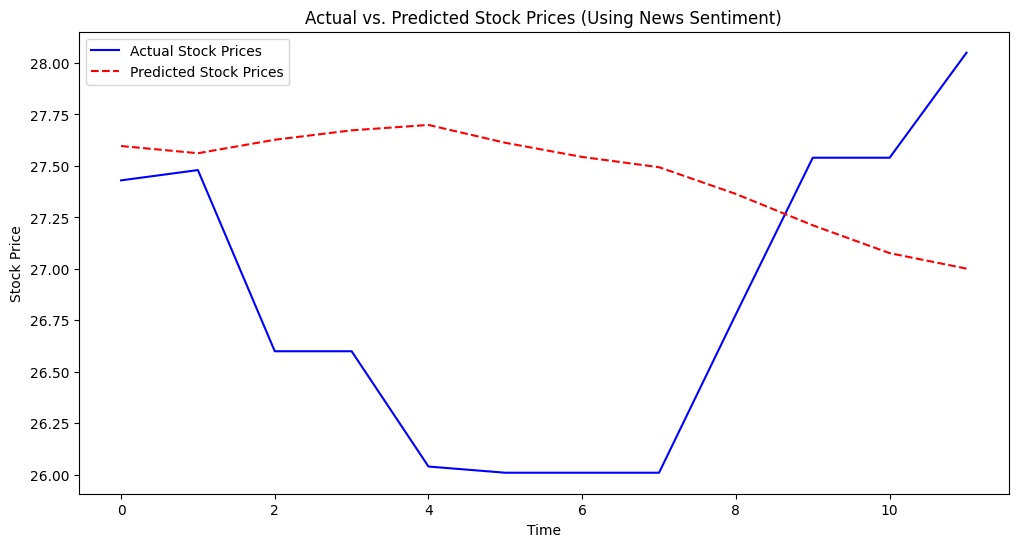

In [39]:
y_pred = model.predict(X_test)
y_pred_unscaled = target_scaler.inverse_transform(y_pred)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Stock Prices", color="blue")
plt.plot(y_pred_unscaled, label="Predicted Stock Prices", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices (Using News Sentiment)")
plt.legend()
plt.show()